In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras


data_path = '/kaggle/input/blood-segmentation-dataset'

(1328, 512, 512, 3)
uint8


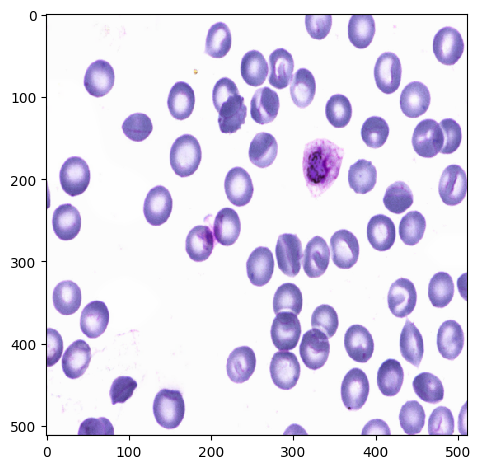

In [2]:
image_data_path ='/kaggle/input/blood-segmentation-dataset/Final data/Final data/New folder/Original'
mask_data_path ='/kaggle/input/blood-segmentation-dataset/Final data/Final data/New folder/Mask'

row = 512
columns = 512

# train_data_path = os.path.join(data_path, 'train')
train_data_path ='/kaggle/input/blood-segmentation-dataset/Final data/Final data/New folder/Original'
training_images = os.listdir(train_data_path)
training_images.sort()

# training_images = images[1::2]
# training_masks = images[::2]
# print(len(training_images)) #20
# print(len(training_masks))

X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    # image.resize((128,128,1))
    X[index] = image
    index += 1

print(X.shape)
#x_train = x_train / 255
#x_train = x_train.astype('float32')
# X = X.astype('float32')
print(X.dtype)
imshow(X[0])

(1328, 512, 512, 3)
uint8


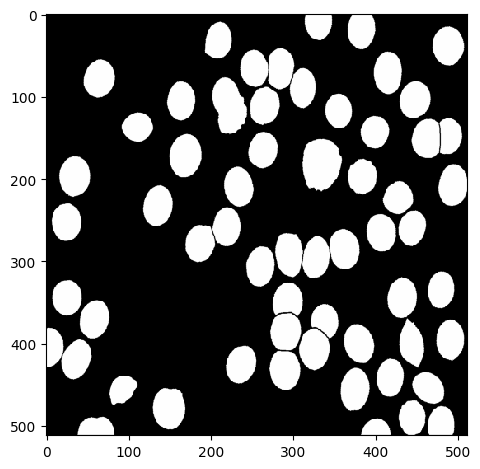

In [3]:
train_data_path ='/kaggle/input/blood-segmentation-dataset/Final data/Final data/New folder/Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)
#p = os.path.join(train_data_path, training_masks[0])
#i = imread(p)
#k = resize(i, (128, 128))
#imshow(k)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
#y_train = y_train / 255
#y_train = y_train.astype('float32')
print(y.dtype)
imshow(y[0])

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

# X_train = X_train.astype('float32')
# y_train = y_train.astype('float32')

# X_test = X_test.astype('float32')
# y_test = y_test.astype('float32')

# print(X_train.dtype)
# print(y_train.dtype)
# print()
# print(X_test.dtype)
# print(y_test.dtype)

(1062, 512, 512, 3)
(1062, 512, 512, 3)

(266, 512, 512, 3)
(266, 512, 512, 3)


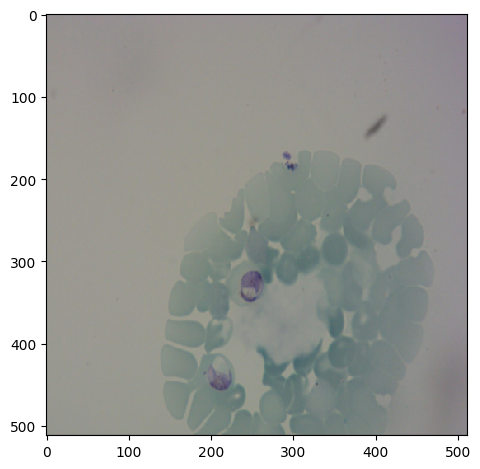

In [5]:
imshow(X_train[0])

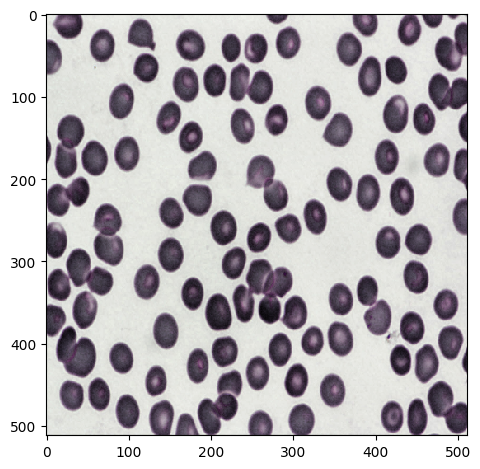

In [6]:
imshow(X_test[0])

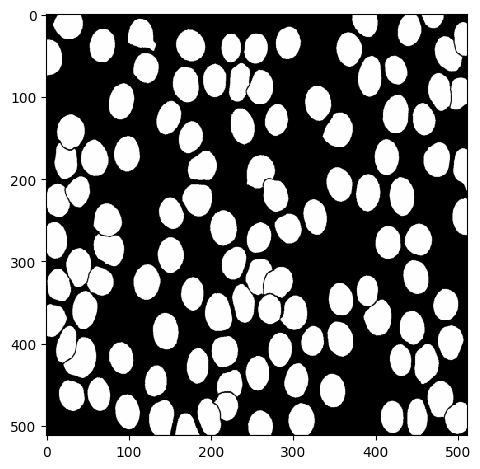

In [7]:
imshow(y_test[0])

In [8]:
y_train = y_train.astype('bool')
print(y_train.dtype)

bool


In [9]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf

In [10]:
def dice_coef(a, b):
    hi = a
#     hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = keras.layers.Flatten()(hi)   #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index(a, b):
    hi = a
#     hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [11]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization


from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

#input_shape = (512, 512, 3)
#n_labels    = 3

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

    opt = keras.optimizers.Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=[dice_coef, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [12]:
input_shape = (512,512,3)
n_labels = 3
model = model_build_func(input_shape, n_labels)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 256, 256,  │          0 │ activation[0][0]  │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ pool3[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool4               │ (None, 32, 32,    │          0 │ activation_6[0][

 Total params: 4,882,083 (18.62 MB)

 Trainable params: 4,873,827 (18.59 MB)

 Non-trainable params: 8,256 (32.25 KB)

In [13]:
print(X_train.dtype)
print(y_train.dtype)

print(type(X_train))
print(type(y_train))

X_train = X_train.astype('uint8')
y_train = y_train.astype('float64')

print(X_train.dtype)
print(y_train.dtype)

uint8
bool
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
uint8
float64


In [14]:
print(X_train.shape)
print(y_train.shape)
filepath = "/kaggle/working/model.keras"
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#mode='min'
callbacks_list = [earlystopper, checkpoint]
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=1, epochs=20, callbacks=callbacks_list)

(1062, 512, 512, 3)
(1062, 512, 512, 3)
Epoch 1/20


I0000 00:00:1725812587.085440      70 service.cc:145] XLA service 0x7aeab4003af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725812587.085502      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725812587.085508      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725812611.056113      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


955/955 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - dice_coef: 0.7914 - jaccard_index: 0.6704 - loss: 0.1946
Epoch 1: val_loss improved from inf to 0.38090, saving model to /kaggle/working/model.keras
955/955 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - dice_coef: 0.7915 - jaccard_index: 0.6704 - loss: 0.1946 - val_dice_coef: 0.8682 - val_jaccard_index: 0.7962 - val_loss: 0.3809
Epoch 2/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - dice_coef: 0.9023 - jaccard_index: 0.8254 - loss: 0.1013
Epoch 2: val_loss improved from 0.38090 to 0.19965, saving model to /kaggle/working/model.keras
955/955 ━━━━━━━━━━━━━━━━━━━━ 146s 153ms/step - dice_coef: 0.9023 - jaccard_index: 0.8254 - loss: 0.1013 - val_dice_coef: 0.8651 - val_jaccard_index: 0.7848 - val_loss: 0.1996
Epoch 3/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - dice_coef: 0.9177 - jaccard_index: 0.8509 - loss: 0.0876
Epoch 3: val_loss improved from 0.19965 to 0.12804, saving model to /kaggle/working/model.keras
955/955 ━━━━━━━━━━━━━━━━━━━━ 147s 154m

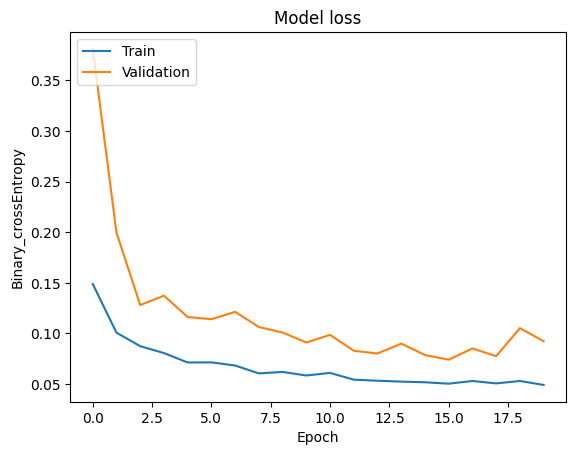

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

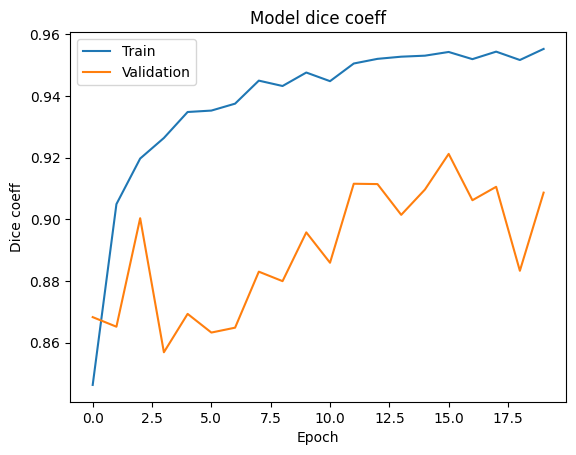

In [16]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

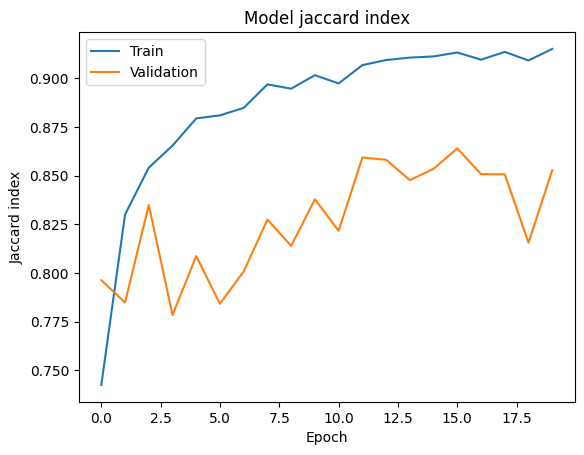

In [17]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
X_test = X_test.astype('uint8')
y_test = y_test.astype('float64')

In [19]:
model.load_weights('/kaggle/working/model.keras')

# Batch predictions to reduce memory usage
test_preds = model.predict(X_test, batch_size = 8)  # Adjust batch size based on GPU memory

print(test_preds.shape)
print(type(test_preds))

2024-09-08 17:13:03.132422: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,96,512,512]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-08 17:13:03.550272: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.41796457s
Trying algorithm eng0{} for conv (f32[8,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,96,512,512]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_o

34/34 ━━━━━━━━━━━━━━━━━━━━ 60s 753ms/step
(266, 512, 512, 3)
<class 'numpy.ndarray'>


In [20]:
def dice_coef2(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi) # K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

float64
float32
Dice Co-efficient:  tf.Tensor(0.9299699, shape=(), dtype=float32)
Jaccard-index:  tf.Tensor(0.86910605, shape=(), dtype=float32)


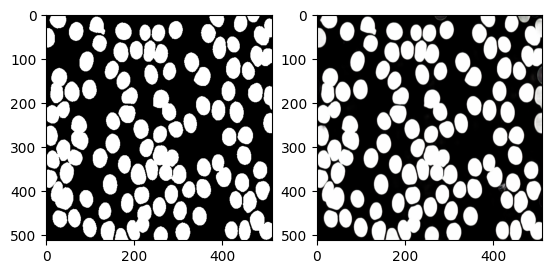

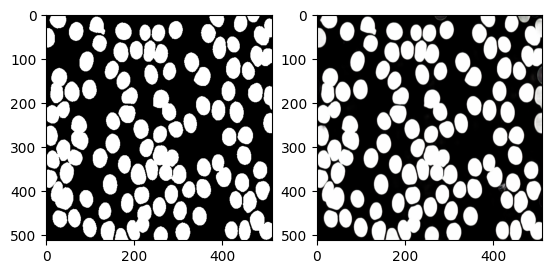

In [21]:
from skimage.io import imshow_collection
print(y_test[0].dtype)
print(test_preds[0].dtype)
i = y_test[0]
j = test_preds[0]
#i = np.asarray(i).astype(dtype=np.float32)
result = dice_coef2(i,j)
#print(tf.get_static_value(result))
print('Dice Co-efficient: ', result)
result2 = jaccard_index2(i,j)
print('Jaccard-index: ', result2)
x = np.zeros((2, row, columns, 3))
x[0] = i
x[1] = j
imshow_collection(x)

In [22]:
#dice_list = np.array(len(test_preds))
#jaccard_list = np.array(len(test_preds))
avg_dice = 0
avg_jaccard = 0
for x in range(len(test_preds)):
    i = y_test[x]
    j = test_preds[x]
    avg_dice = avg_dice + tf.get_static_value(dice_coef2(i,j))
    avg_jaccard = avg_jaccard + tf.get_static_value(jaccard_index2(i,j))
    
#print(dice_list.dtype)
#print(type(dice_list))
#print(dice_list)
#print(jaccard_list)
#avg_dice = tf.get_static_value(K.sum(dice_list)) / tf.get_static_value(tf.size(dice_list))
#avg_jaccard = tf.get_static_value(K.sum(jaccard_list)) / tf.get_static_value(tf.size(jaccard_list))
print('Average Test Dice co-efficent: ', avg_dice/len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard/len(test_preds))

Average Test Dice co-efficent:  0.886729549644585
Average Test Jaccrad Index:  0.807911585316174


In [23]:
print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  0.04920882731676102
Lowest validation loss:  0.07410777360200882
Highest training dice coefficient:  0.9552441239356995
Highest validation dice coefficient:  0.9211933612823486
Highest training jaccrad index:  0.9150097370147705
Highest validation jaccard index:  0.8638954758644104
